In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import unicodedata
import numpy as np
import re

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import warnings
warnings.filterwarnings('ignore')

from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ansam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ansam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ansam\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

Documentation:

* nltk: https://www.nltk.org/
* Textblob: https://textblob.readthedocs.io/en/dev/
* wordcloud: https://amueller.github.io/word_cloud/

In [2]:
data = pd.read_csv('../data/Categories and prompts and ratings.csv')
data.head()

,Topic,Prompt Nr,Prompt,Model,Actual Model (Fill in after Rating is complete),Response,Rating Christine,Comments Christine,Rating Ansam,Comment Ansam,Rating Adrian,Comment Adrian,Rating Mike,Comment Mike,Rating Albin,Comment Albin,Rating Grzegorz,Comment Grzegorz,Translation Language,Translation Type
0,Creativity (Christine),1.0,Write a Haiku about a fork,1.0,ChatGPT 3.5,"Silver prongs reach out, Guiding food from pla...",8.0,Simple yet efficient,7.0,"Creative, I know what it's talking about",7.0,"Structure matches, feels bland though",8.0,"Is a Haiku, nice!",8.0,first 2 lines really good.,7.0,Nice wording,NaN,NaN
1,NaN,NaN,NaN,2.0,ChatGPT 4,"In hands it dances, Tines whisper through the ...",4.0,Confusing,6.0,Not bad but too vague,7.0,"Structure matches, can't judge it really",4.0,"Not quite Haiku, not so specific",6.0,unclear,6.0,Just ok,NaN,NaN
2,NaN,NaN,NaN,3.0,Gemini,"Curved metal tines gleam, Separates bites, a ...",4.0,Confusing,9.0,"Creative, accurate, made me smile",4.0,"Structure mismatch, I don't get it",3.0,"Not quite Haiku, too long",4.0,incorrect format,10.0,"The best in this category. Creative, funny",NaN,NaN
3,NaN,NaN,NaN,4.0,Gemini Advanced,"Metal tines curve up, Ready to capture and lif...",8.0,Cute,10.0,Love the use of words to describe it,5.0,"Structure matches, but feels basic",9.0,"Is a Haiku, focuses on fork, really like this",7.0,good wording,8.0,"Nice wording, creative",NaN,NaN
4,NaN,NaN,NaN,5.0,LLaMA 70b,"Tines raised high Food's best friend, a humble...",6.0,Confusing,5.0,Confusing and trying too hard,3.0,"Structure mismatch, feels clumsy",7.0,"Is a Haiku, like this one too",4.0,incorrect format,5.0,The worst in this category. Boring,NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 20 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Topic                                            6 non-null      object 
 1   Prompt Nr                                        18 non-null     float64
 2   Prompt                                           18 non-null     object 
 3   Model                                            215 non-null    float64
 4   Actual Model (Fill in after Rating is complete)  215 non-null    object 
 5   Response                                         215 non-null    object 
 6   Rating Christine                                 215 non-null    float64
 7   Comments Christine                               145 non-null    object 
 8   Rating Ansam                                     215 non-null    float64
 9   Comment Ansam                   

# Data cleaning

In [4]:
data.columns

Index(['Topic', 'Prompt Nr', 'Prompt', 'Model',
       'Actual Model (Fill in after Rating is complete)', 'Response',
       'Rating Christine', 'Comments Christine', 'Rating Ansam',
       'Comment Ansam', 'Rating Adrian', 'Comment Adrian', 'Rating Mike',
       'Comment Mike', 'Rating Albin', 'Comment Albin', 'Rating Grzegorz',
       'Comment Grzegorz', 'Translation Language', 'Translation Type'],
      dtype='object')

In [5]:
# filling the empty columns with missing data about topics, pormpt number and prompt
data['Topic'].fillna(method='ffill', inplace=True)
data['Prompt Nr'].fillna(method='ffill', inplace=True)
data['Prompt'].fillna(method='ffill', inplace=True)

In [6]:
# replace space with _ for column names for easier coding

data.columns = data.columns.str.replace(' ', '_')
data.columns

Index(['Topic', 'Prompt_Nr', 'Prompt', 'Model',
       'Actual_Model_(Fill_in_after_Rating_is_complete)', 'Response',
       'Rating_Christine', 'Comments_Christine', 'Rating_Ansam',
       'Comment_Ansam', 'Rating_Adrian', 'Comment_Adrian', 'Rating_Mike',
       'Comment_Mike', 'Rating_Albin', 'Comment_Albin', 'Rating_Grzegorz',
       'Comment_Grzegorz', 'Translation_Language', 'Translation_Type'],
      dtype='object')

In [7]:
data['Topic'].unique()

array(['Creativity (Christine)', 'Math (Ansam)',
       'Theory of Mind (Adrian)', 'Intuitive Physics (Mike)',
       'Idea Generation (Albin)', 'Translation (Grzegorz)'], dtype=object)

In [8]:
# edit topic name without our personal names
data['Topic'] = data['Topic'].str.replace(r'\(.*?\)', '', regex=True).str.strip()

In [9]:
# delete rows where there is no prompt or prompt number 

data = data.dropna(subset=['Model', 'Actual_Model_(Fill_in_after_Rating_is_complete)'], how='all')
data.head(5)

,Topic,Prompt_Nr,Prompt,Model,Actual_Model_(Fill_in_after_Rating_is_complete),Response,Rating_Christine,Comments_Christine,Rating_Ansam,Comment_Ansam,Rating_Adrian,Comment_Adrian,Rating_Mike,Comment_Mike,Rating_Albin,Comment_Albin,Rating_Grzegorz,Comment_Grzegorz,Translation_Language,Translation_Type
0,Creativity,1.0,Write a Haiku about a fork,1.0,ChatGPT 3.5,"Silver prongs reach out, Guiding food from pla...",8.0,Simple yet efficient,7.0,"Creative, I know what it's talking about",7.0,"Structure matches, feels bland though",8.0,"Is a Haiku, nice!",8.0,first 2 lines really good.,7.0,Nice wording,NaN,NaN
1,Creativity,1.0,Write a Haiku about a fork,2.0,ChatGPT 4,"In hands it dances, Tines whisper through the ...",4.0,Confusing,6.0,Not bad but too vague,7.0,"Structure matches, can't judge it really",4.0,"Not quite Haiku, not so specific",6.0,unclear,6.0,Just ok,NaN,NaN
2,Creativity,1.0,Write a Haiku about a fork,3.0,Gemini,"Curved metal tines gleam, Separates bites, a ...",4.0,Confusing,9.0,"Creative, accurate, made me smile",4.0,"Structure mismatch, I don't get it",3.0,"Not quite Haiku, too long",4.0,incorrect format,10.0,"The best in this category. Creative, funny",NaN,NaN
3,Creativity,1.0,Write a Haiku about a fork,4.0,Gemini Advanced,"Metal tines curve up, Ready to capture and lif...",8.0,Cute,10.0,Love the use of words to describe it,5.0,"Structure matches, but feels basic",9.0,"Is a Haiku, focuses on fork, really like this",7.0,good wording,8.0,"Nice wording, creative",NaN,NaN
4,Creativity,1.0,Write a Haiku about a fork,5.0,LLaMA 70b,"Tines raised high Food's best friend, a humble...",6.0,Confusing,5.0,Confusing and trying too hard,3.0,"Structure mismatch, feels clumsy",7.0,"Is a Haiku, like this one too",4.0,incorrect format,5.0,The worst in this category. Boring,NaN,NaN


In [10]:
data = data.rename(columns={'Actual_Model_(Fill_in_after_Rating_is_complete)': 'Model_Name'})

Cleaning for sentiment analysis

In [11]:
# text cleaning 
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text) 
    return text

def clean_text(text):
    text = re.sub(r"@[A-Za-z0–9]+", "", text) # Remove @mentions replace with blank
    text = re.sub(r"#", "", text) # Remove the ‘#’ symbol, replace with blank
    text = re.sub(r"RT[\s]+", "", text) # Removing RT, replace with blank
    text = re.sub(r"https?:\/\/\S+", "", text) # Remove the hyperlinks
    text = re.sub(r":", "", text) # Remove :
    return text

def remove_emojis(text):
    emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F" # emoticons
    u"\U0001F300-\U0001F5FF" # symbols & pictographs
    u"\U0001F680-\U0001F6FF" # transport & map symbols
    u"\U0001F1E0-\U0001F1FF" # flags (iOS)
    u"\U00002500-\U00002BEF" # chinese char
    u"\U00002702-\U000027B0"
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u"\U00010000-\U0010ffff"
    u"\u2640-\u2642"
    u"\u2600-\u2B55"
    u"\u200d"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\ufe0f" # dingbats
    u"\u3030"
    "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [12]:
def clean_column(df, column_name):
    df[column_name] = df[column_name].apply(remove_accented_chars)
    df[column_name] = df[column_name].apply(remove_special_characters)
    df[column_name] = df[column_name].apply(clean_text)
    df[column_name] = df[column_name].apply(remove_emojis)
    return df

In [13]:
# this will be used for the word cloud

def remove_stopwords(text, is_lower_case=False, stopwords=None):
    if not stopwords:
        stopwords = nltk.corpus.stopwords.words('english')
    tokens = nltk.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopwords]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [14]:
for colname in ['Comments_Christine', 'Comment_Ansam', 'Comment_Adrian', 'Comment_Mike', 'Comment_Albin', 'Comment_Grzegorz']:
    data[colname] = data[colname].replace(np.nan, 'No comment')
    data = clean_column(data, colname)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 215 entries, 0 to 219
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Topic                 215 non-null    object 
 1   Prompt_Nr             215 non-null    float64
 2   Prompt                215 non-null    object 
 3   Model                 215 non-null    float64
 4   Model_Name            215 non-null    object 
 5   Response              215 non-null    object 
 6   Rating_Christine      215 non-null    float64
 7   Comments_Christine    215 non-null    object 
 8   Rating_Ansam          215 non-null    float64
 9   Comment_Ansam         215 non-null    object 
 10  Rating_Adrian         215 non-null    float64
 11  Comment_Adrian        215 non-null    object 
 12  Rating_Mike           211 non-null    float64
 13  Comment_Mike          215 non-null    object 
 14  Rating_Albin          215 non-null    float64
 15  Comment_Albin         215 no

# Calculations

### Average rating for each prompt

In [16]:
data['Average_rating'] = data[['Rating_Christine', 'Rating_Ansam', 'Rating_Adrian', 'Rating_Mike', 'Rating_Albin', 'Rating_Grzegorz']].mean(axis=1)
data.head()

,Topic,Prompt_Nr,Prompt,Model,Model_Name,Response,Rating_Christine,Comments_Christine,Rating_Ansam,Comment_Ansam,Rating_Adrian,Comment_Adrian,Rating_Mike,Comment_Mike,Rating_Albin,Comment_Albin,Rating_Grzegorz,Comment_Grzegorz,Translation_Language,Translation_Type,Average_rating
0,Creativity,1.0,Write a Haiku about a fork,1.0,ChatGPT 3.5,"Silver prongs reach out, Guiding food from pla...",8.0,Simple yet efficient,7.0,Creative I know what its talking about,7.0,Structure matches feels bland though,8.0,Is a Haiku nice,8.0,first 2 lines really good,7.0,Nice wording,NaN,NaN,7.500000
1,Creativity,1.0,Write a Haiku about a fork,2.0,ChatGPT 4,"In hands it dances, Tines whisper through the ...",4.0,Confusing,6.0,Not bad but too vague,7.0,Structure matches cant judge it really,4.0,Not quite Haiku not so specific,6.0,unclear,6.0,Just ok,NaN,NaN,5.500000
2,Creativity,1.0,Write a Haiku about a fork,3.0,Gemini,"Curved metal tines gleam, Separates bites, a ...",4.0,Confusing,9.0,Creative accurate made me smile,4.0,Structure mismatch I dont get it,3.0,Not quite Haiku too long,4.0,incorrect format,10.0,The best in this category Creative funny,NaN,NaN,5.666667
3,Creativity,1.0,Write a Haiku about a fork,4.0,Gemini Advanced,"Metal tines curve up, Ready to capture and lif...",8.0,Cute,10.0,Love the use of words to describe it,5.0,Structure matches but feels basic,9.0,Is a Haiku focuses on fork really like this,7.0,good wording,8.0,Nice wording creative,NaN,NaN,7.833333
4,Creativity,1.0,Write a Haiku about a fork,5.0,LLaMA 70b,"Tines raised high Food's best friend, a humble...",6.0,Confusing,5.0,Confusing and trying too hard,3.0,Structure mismatch feels clumsy,7.0,Is a Haiku like this one too,4.0,incorrect format,5.0,The worst in this category Boring,NaN,NaN,5.000000


### Group by topic

In [17]:
data_gb_topic = data.groupby('Topic').agg({'Average_rating':'mean'}).reset_index()
data_gb_topic

,Topic,Average_rating
0,Creativity,6.444444
1,Idea Generation,7.166667
2,Intuitive Physics,6.666667
3,Math,6.082222
4,Theory of Mind,7.800000
5,Translation,6.457143


### Group by Model

In [18]:
data_gb_model = data.groupby('Model_Name').agg({'Average_rating':'mean'}).reset_index()
data_gb_model

,Model_Name,Average_rating
0,ChatGPT 3.5,6.534884
1,ChatGPT 4,7.831783
2,Gemini,7.127907
3,Gemini Advanced,7.125581
4,LLaMA 70b,4.319380


# Visualizations

How did models in general do in each topic?

In [19]:
fig = px.bar(data_gb_topic, x='Topic', y='Average_rating', 
             title='Average Rating per Topic',
             color='Topic') 

# add average labels on top of the bars
for trace in fig.data:
    for i, value in enumerate(trace['y']):
        fig.add_annotation(
            x=trace['x'][i],
            y=value+0.35,
            text=str(round(value, 2)),
            showarrow=False,
            font=dict(color='black')
        )

fig.update_layout(showlegend=False)

fig.show()


The distribution of ratings for each topic

In [20]:
fig = px.box(data, x='Topic', y='Average_rating', title='Rating Distribution by Topic', color='Topic')
fig.update_layout(showlegend=False)
fig.show()

How did each model do in each topic?

In [21]:
fig = px.bar(data_gb_model, x='Model_Name', y='Average_rating', 
             title='Average Rating per Model',
             color='Model_Name') 

# add average labels on top of the bars
for trace in fig.data:
    for i, value in enumerate(trace['y']):
        fig.add_annotation(
            x=trace['x'][i],
            y=value+0.35,
            text=str(round(value, 2)),
            showarrow=False,
            font=dict(color='black')
        )

fig.update_layout(showlegend=False)

fig.show()

The distribution of ratings for each model

In [22]:
fig = px.box(data, x='Model_Name', 
             y='Average_rating', title='Rating Distribution by Model', color='Model_Name')
fig.update_layout(showlegend=False)
fig.show()

How did each model do in all topic?

In [23]:
models = data['Model_Name'].unique()
topics = data['Topic'].unique()

rows = len(models)
fig = make_subplots(rows=rows, cols=1, subplot_titles=models, vertical_spacing=0.05)

colors = ['#7fc97f', '#beaed4', '#fdc086', '#ffff99', '#386cb0', '#f0027f']

for i, model in enumerate(models, start=1):
    model_data = data[data['Model_Name'] == model]
    for j, topic in enumerate(topics):
        avg_rating = model_data[model_data['Topic'] == topic]['Average_rating'].values[0]
        fig.add_trace(go.Bar(x=[topic], y=[avg_rating], name=topic, marker_color=colors[j % len(colors)]), row=i, col=1)
        
        fig.add_annotation(x=topic, y=avg_rating+0.4, text=str(round(avg_rating,2)), showarrow=False, row=i, col=1)

fig.update_layout(height=1000, width=1000, title_text="Model Performance by Topic", showlegend=False)
fig.show()

Distribution of Ratings by Reviewer

In [24]:
ratings_data = data.filter(like='Rating').melt(var_name='Reviewer', value_name='Rating')

In [25]:
fig = px.box(ratings_data, x='Reviewer', y='Rating', color='Reviewer', 
             title='Distribution of Ratings by Reviewer')

fig.update_layout(showlegend=False)
fig.show()

Analyze if the length of the AI-generated response has any correlation with the rating it receives

In [26]:
# Calculate the length of each response
data['Response_Length'] = data['Response'].astype(str).apply(len)

# Average the ratings across all reviewers for each response
rating_columns = ['Rating_Christine', 'Rating_Ansam', 'Rating_Adrian', 'Rating_Mike', 'Rating_Albin', 'Rating_Grzegorz']

# Prepare data for plotting
plot_data = data[['Response_Length', 'Average_rating']].dropna()

# Create a scatter plot to visualize the correlation between response length and average rating
fig = px.scatter(plot_data, x='Response_Length', y='Average_rating', trendline='ols',
                 title='Response Length vs. Average Rating',
                 labels={'Response_Length': 'Response Length (characters)', 'Average_rating': 'Average Rating'})

fig.show()

# Sentiment Analysis

In [27]:
sia = SentimentIntensityAnalyzer()

In [28]:
comment_columns = [col for col in data.columns if 'Comment' in col]
comment_columns

['Comments_Christine',
 'Comment_Ansam',
 'Comment_Adrian',
 'Comment_Mike',
 'Comment_Albin',
 'Comment_Grzegorz']

In [40]:
def Sentiment(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [41]:
for colname in comment_columns:
    data[f'{colname}_Sentiment'] = data[colname].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'])
    data[f'{colname}_Sentiment_analysis'] = data[f'{colname}_Sentiment'].apply(Sentiment)

In [42]:
data.columns

Index(['Topic', 'Prompt_Nr', 'Prompt', 'Model', 'Model_Name', 'Response',
       'Rating_Christine', 'Comments_Christine', 'Rating_Ansam',
       'Comment_Ansam', 'Rating_Adrian', 'Comment_Adrian', 'Rating_Mike',
       'Comment_Mike', 'Rating_Albin', 'Comment_Albin', 'Rating_Grzegorz',
       'Comment_Grzegorz', 'Translation_Language', 'Translation_Type',
       'Average_rating', 'Response_Length', 'Comments_Christine_Sentiment',
       'Comment_Ansam_Sentiment', 'Comment_Adrian_Sentiment',
       'Comment_Mike_Sentiment', 'Comment_Albin_Sentiment',
       'Comment_Grzegorz_Sentiment', 'Comments_Christine_Sentiment_analysis',
       'Comment_Ansam_Sentiment_analysis', 'Comment_Adrian_Sentiment_analysis',
       'Comment_Mike_Sentiment_analysis', 'Comment_Albin_Sentiment_analysis',
       'Comment_Grzegorz_Sentiment_analysis'],
      dtype='object')

In [43]:
data.head()

,Topic,Prompt_Nr,Prompt,Model,Model_Name,Response,Rating_Christine,Comments_Christine,Rating_Ansam,Comment_Ansam,Rating_Adrian,Comment_Adrian,Rating_Mike,Comment_Mike,Rating_Albin,Comment_Albin,Rating_Grzegorz,Comment_Grzegorz,Translation_Language,Translation_Type,Average_rating,Response_Length,Comments_Christine_Sentiment,Comment_Ansam_Sentiment,Comment_Adrian_Sentiment,Comment_Mike_Sentiment,Comment_Albin_Sentiment,Comment_Grzegorz_Sentiment,Comments_Christine_Sentiment_analysis,Comment_Ansam_Sentiment_analysis,Comment_Adrian_Sentiment_analysis,Comment_Mike_Sentiment_analysis,Comment_Albin_Sentiment_analysis,Comment_Grzegorz_Sentiment_analysis
0,Creativity,1.0,Write a Haiku about a fork,1.0,ChatGPT 3.5,"Silver prongs reach out, Guiding food from pla...",8.0,Simple yet efficient,7.0,Creative I know what its talking about,7.0,Structure matches feels bland though,8.0,Is a Haiku nice,8.0,first 2 lines really good,7.0,Nice wording,NaN,NaN,7.500000,81,0.4215,0.4404,0.0,0.4215,0.4927,0.4215,Positive,Positive,Neutral,Positive,Positive,Positive
1,Creativity,1.0,Write a Haiku about a fork,2.0,ChatGPT 4,"In hands it dances, Tines whisper through the ...",4.0,Confusing,6.0,Not bad but too vague,7.0,Structure matches cant judge it really,4.0,Not quite Haiku not so specific,6.0,unclear,6.0,Just ok,NaN,NaN,5.500000,81,-0.2263,0.0836,0.0,0.0000,-0.2500,0.2960,Negative,Positive,Neutral,Neutral,Negative,Positive
2,Creativity,1.0,Write a Haiku about a fork,3.0,Gemini,"Curved metal tines gleam, Separates bites, a ...",4.0,Confusing,9.0,Creative accurate made me smile,4.0,Structure mismatch I dont get it,3.0,Not quite Haiku too long,4.0,incorrect format,10.0,The best in this category Creative funny,NaN,NaN,5.666667,88,-0.2263,0.6597,0.0,0.0000,0.0000,0.8750,Negative,Positive,Neutral,Neutral,Neutral,Positive
3,Creativity,1.0,Write a Haiku about a fork,4.0,Gemini Advanced,"Metal tines curve up, Ready to capture and lif...",8.0,Cute,10.0,Love the use of words to describe it,5.0,Structure matches but feels basic,9.0,Is a Haiku focuses on fork really like this,7.0,good wording,8.0,Nice wording creative,NaN,NaN,7.833333,69,0.4588,0.6369,0.0,0.4201,0.4404,0.6908,Positive,Positive,Neutral,Positive,Positive,Positive
4,Creativity,1.0,Write a Haiku about a fork,5.0,LLaMA 70b,"Tines raised high Food's best friend, a humble...",6.0,Confusing,5.0,Confusing and trying too hard,3.0,Structure mismatch feels clumsy,7.0,Is a Haiku like this one too,4.0,incorrect format,5.0,The worst in this category Boring,NaN,NaN,5.000000,70,-0.2263,-0.3182,0.0,0.3612,0.0000,-0.7506,Negative,Negative,Neutral,Positive,Neutral,Negative


(-0.5, 999.5, 599.5, -0.5)

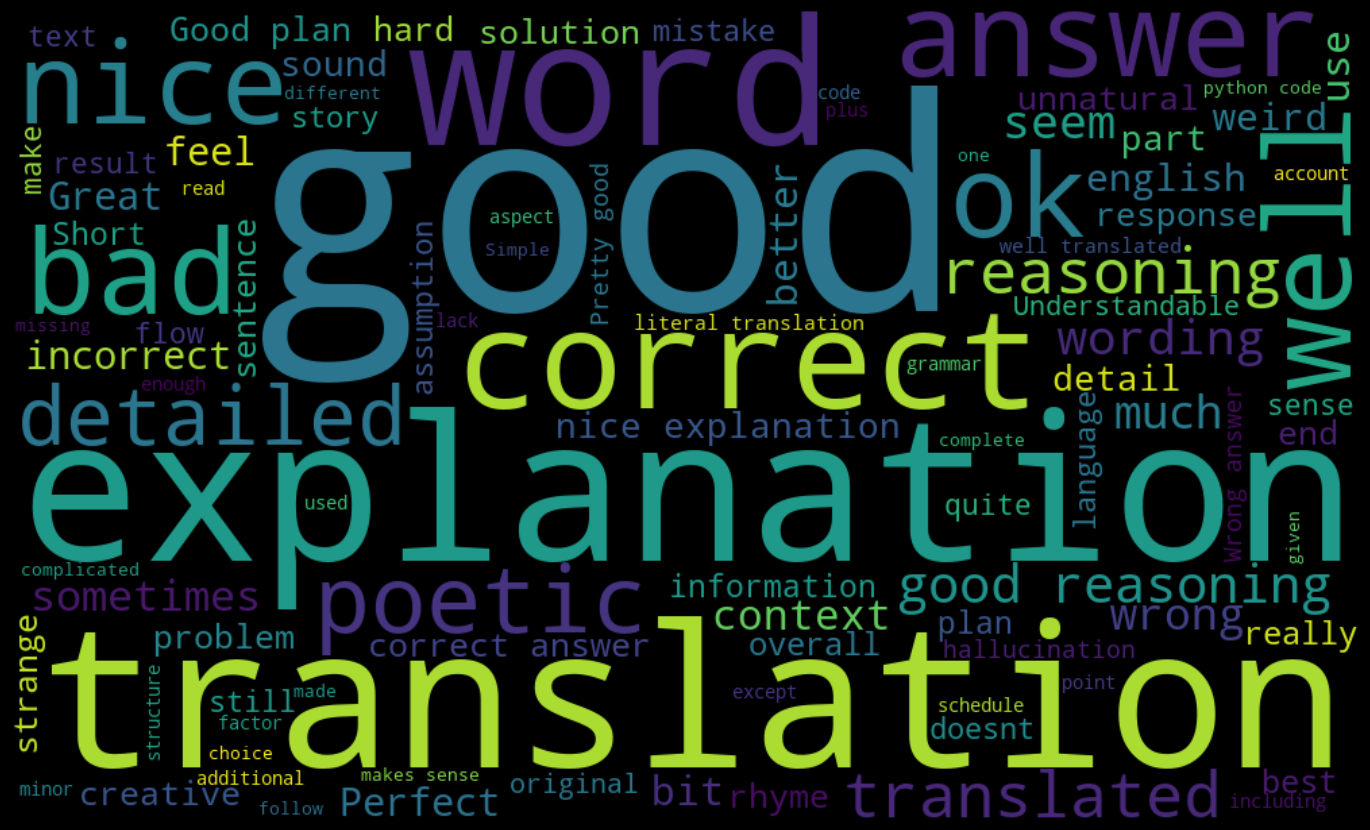

In [30]:
viz_data = data.copy(deep=True)

viz_data['all_comments'] = viz_data[['Comments_Christine', 'Comment_Ansam', 'Comment_Adrian', 'Comment_Mike', 'Comment_Albin', 'Comment_Grzegorz']].agg(' '.join, axis=1)

# removing stop words for visualizations only because it reduced the polarity for some text
viz_data['all_comments'] = viz_data['all_comments'].apply(remove_stopwords)

# To join all
text = ''.join([post for post in viz_data['all_comments']])

for word_remove in ['No comment', 'comment', 'commentcomment']:
    text = text.replace(word_remove, '')

# generate word cloud 
stopwords = STOPWORDS
wordcloud = WordCloud(width=1000, height = 600, 
                      max_words = 100,
                      stopwords = stopwords,
                      background_color='black').generate(text)

# Display the generated image:
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

Correlation between Comment Sentiments and Average Rating

In [31]:
data.columns

Index(['Topic', 'Prompt_Nr', 'Prompt', 'Model', 'Model_Name', 'Response',
       'Rating_Christine', 'Comments_Christine', 'Rating_Ansam',
       'Comment_Ansam', 'Rating_Adrian', 'Comment_Adrian', 'Rating_Mike',
       'Comment_Mike', 'Rating_Albin', 'Comment_Albin', 'Rating_Grzegorz',
       'Comment_Grzegorz', 'Translation_Language', 'Translation_Type',
       'Average_rating', 'Response_Length', 'Comments_Christine_Sentiment',
       'Comment_Ansam_Sentiment', 'Comment_Adrian_Sentiment',
       'Comment_Mike_Sentiment', 'Comment_Albin_Sentiment',
       'Comment_Grzegorz_Sentiment'],
      dtype='object')

In [32]:
fig = px.scatter(data, x=f'{comment_columns[0]}_Sentiment', y='Average_rating',
                 title=f'Sentiment vs. Average Rating',
                 labels={f'{comment_columns[0]}_Sentiment': 'Sentiment Score', 'AveragAverage_ratinge_Rating': 'Average Rating'},
                 trendline='ols') 

fig.show()

In [33]:
correlation_columns = [f'{col}_Sentiment' for col in comment_columns] + ['Average_rating']
correlation_matrix = data[correlation_columns].corr()

# Use Plotly to create a heatmap
fig = ff.create_annotated_heatmap(
    z=correlation_matrix.values,
    x=correlation_matrix.columns.tolist(),
    y=correlation_matrix.index.tolist(),
    colorscale='Viridis',
    annotation_text=correlation_matrix.round(2).values,
    showscale=True
)

fig.update_layout(title_text='Correlation between Comment Sentiments and Average Rating',
                  xaxis=dict(tickangle=0)
                  )
fig.update_layout(height=1000, width=1700)
fig.show()

Sentiment Distribution Across Comments

In [44]:
fig = px.histogram(data, x=['Comments_Christine_Sentiment_analysis', 'Comment_Ansam_Sentiment_analysis', 
                            'Comment_Adrian_Sentiment_analysis', 'Comment_Mike_Sentiment_analysis', 
                            'Comment_Albin_Sentiment_analysis', 'Comment_Grzegorz_Sentiment_analysis'],
                   barmode='group', title='Sentiment Distribution Across Comments')
fig.show()

In [56]:
melted_data = data.melt(value_vars=['Comments_Christine_Sentiment', 'Comment_Ansam_Sentiment', 
                                    'Comment_Adrian_Sentiment', 'Comment_Mike_Sentiment', 
                                    'Comment_Albin_Sentiment', 'Comment_Grzegorz_Sentiment'],
                        var_name='Sentiment_Source', value_name='Sentiment_Score')

fig = px.violin(melted_data, x='Sentiment_Source', y='Sentiment_Score', color='Sentiment_Source',
                box=True, points='all', title='Sentiment Score Distribution',
                category_orders={"Sentiment_Source": ['Comments_Christine_Sentiment', 'Comment_Ansam_Sentiment', 
                                                       'Comment_Adrian_Sentiment', 'Comment_Mike_Sentiment', 
                                                       'Comment_Albin_Sentiment', 'Comment_Grzegorz_Sentiment']})

fig.update_traces(marker=dict(opacity=0.5))
fig.update_layout(showlegend=False)
# fig.update_xaxes(tickangle=-45)

fig.show()

Average Sentiment Score by Model

In [48]:
data['Average_Sentiment_Score'] = data[['Comments_Christine_Sentiment', 'Comment_Ansam_Sentiment', 
                                        'Comment_Adrian_Sentiment', 'Comment_Mike_Sentiment', 
                                        'Comment_Albin_Sentiment', 'Comment_Grzegorz_Sentiment']].mean(axis=1)
average_sentiment_by_model = data.groupby('Model_Name')['Average_Sentiment_Score'].mean().reset_index()

fig = px.bar(average_sentiment_by_model, x='Model_Name', y='Average_Sentiment_Score', color='Model_Name',
             title='Average Sentiment Score by Model')
fig.update_layout(showlegend=False)
fig.show()

## Linguistic analysis

Decided not to use it, was just a trial

In [34]:
# Part-of-Speech Tagging
import spacy

In [35]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 682.7 kB/s eta 0:00:19
     ---------------------------------------- 0.1/12.8 MB 1.4 MB/s eta 0:00:09
     - -------------------------------------- 0.5/12.8 MB 3.5 MB/s eta 0:00:04
     -- ------------------------------------- 0.9/12.8 MB 5.4 MB/s eta 0:00:03
     ---- ----------------------------------- 1.5/12.8 MB 6.8 MB/s eta 0:00:02
     ------- -------------------------------- 2.3/12.8 MB 8.5 MB/s eta 0:00:02
     --------- ------------------------------ 3.1/12.8 MB 9.4 MB/s eta 0:00:02
     ----------- ---------------------------- 3.7/12.8 MB 9.9 MB/s eta 0:00:01
     ------------- -------------------------- 4.4/12.8 MB 10.3 MB/s eta 0:00:01
     --------------- ------------------------ 5.0/12.8 MB 11.0 MB/s eta 0:00:01
     ----------------- ---------------------- 5.6/12.8 MB 11.2 MB/s eta 0:00:01
     ------------------- -------------------- 6.2/12.8 

In [36]:
nlp = spacy.load("en_core_web_sm")

In [37]:
def analyze_entities(text):
    doc = nlp(text)
    for entity in doc.ents:
        print(entity.text, entity.label_, entity.start_char, entity.end_char)

In [38]:
data.Response[10]

"As they ascended the winding trail, the sky transformed with capricious abandon, shifting hues from cerulean to ominous gray in the span of mere minutes. Sunlight danced through wisps of cloud, casting fleeting shadows upon the verdant landscape. A gentle breeze whispered secrets through the swaying branches, only to be drowned out by the sudden onslaught of rain that pelted down like a thousand tiny drumbeats. Undeterred, they pressed forward, their spirits buoyed by the ever-changing spectacle unfolding above. Through sunbursts and showers, they traversed the wild terrain, each moment a testament to the unpredictable beauty of nature's whims. And as the sun dipped below the horizon, painting the sky in a riot of fiery hues, they emerged from the forest, hearts full, having journeyed through a kaleidoscope of weather on their unforgettable hike."

In [39]:
review_text = data.Response[10]
analyze_entities(review_text)

of mere minutes TIME 137 152
a thousand CARDINAL 388 398
